In this article, I would like to demonstrate the fine tuning of an existing model with custom dataset, so as to perform the process of textual data summarisation.

Before we start, I would like to mention a quick fun fact about the types of summarisation, which are :
1. **Extractive** : This method identifies key sentences from the original text and combines them to form a summary. It's like creating a highlight reel of the most important points.
2. **Abstractive** : This goes beyond copying sentences. It analyzes the text, understands its meaning, and generates a new, concise summary that captures the essence of the original. It's like writing a short story based on the main plot points.

With that being said, let's embark on our project and see how we can fine-tune a model for summarization using a custom dataset!

# Importing the dependencies

In [1]:
# Let us first check the GPU resource available
!nvidia-smi

Fri Jun 14 10:42:00 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!pip install datasets sacrebleu rouge_score py7zr transformers[sentencepiece] -q
!pip install --upgrade transformers accelerate -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 14.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 62.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.8/413.8 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.9/138.9 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.

In [32]:
from transformers import pipeline, set_seed
from datasets import load_dataset, load_from_disk
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from datasets import load_metric
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorForSeq2Seq

import nltk
from nltk.tokenize import sent_tokenize

from tqdm import tqdm
import torch

nltk.download("punkt")
device = "cuda" if torch.cuda.is_available() else "cpu"

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Importing the Base Model
Here, we will be using the **pegasus-cnn_dailymail** model by **Google**, a model pre-trained on summarzing textual data as well. This model can be found [here](https://huggingface.co/google/pegasus-cnn_dailymail).

In [4]:
model="google/pegasus-cnn_dailymail"

In [5]:
tokenizer = AutoTokenizer.from_pretrained(model)

tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

In [6]:
# Loading the model on our GPU
model = AutoModelForSeq2SeqLM.from_pretrained(model).to(device)

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

Let us now see how the model is defined.

In [7]:
model

PegasusForConditionalGeneration(
  (model): PegasusModel(
    (shared): Embedding(96103, 1024, padding_idx=0)
    (encoder): PegasusEncoder(
      (embed_tokens): Embedding(96103, 1024, padding_idx=0)
      (embed_positions): PegasusSinusoidalPositionalEmbedding(1024, 1024)
      (layers): ModuleList(
        (0-15): 16 x PegasusEncoderLayer(
          (self_attn): PegasusAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): ReLU()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_no

# Loading the Dataset for fine tuning our model
We will be using the SAMSum dataset, which contains about 16k messenger-like conversations with summaries. Conversations were created and written down by linguists fluent in English. Linguists were asked to create conversations similar to those they write on a daily basis, reflecting the proportion of topics of their real-life messenger convesations. You can find it [here](https://huggingface.co/datasets/Samsung/samsum).

In [8]:
dataset = load_dataset("samsum",trust_remote_code=True)
dataset

Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
})

As we can see, the dataset has been split in the form of training, validation and testing datasets.

In [9]:
split_lengths = [len(dataset[split])for split in dataset]

print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset['train'].column_names}")

Split lengths: [14732, 819, 818]
Features: ['id', 'dialogue', 'summary']


Now, let us look at an example of how the dialouge and summary actually are.

In [10]:
print("\033[1mDialogue\033[0m:")
print(dataset["test"][10]["dialogue"])
print("\n\033[1mSummary\033[0m:")
print(dataset["test"][10]["summary"])

Dialogue:
Wanda: Let's make a party!
Gina: Why?
Wanda: beacuse. I want some fun!
Gina: ok, what do u need?
Wanda: 1st I need too make a list
Gina: noted and then?
Wanda: well, could u take yours father car and go do groceries with me?
Gina: don't know if he'll agree
Wanda: I know, but u can ask :)
Gina: I'll try but theres no promisess
Wanda: I know, u r the best!
Gina: When u wanna go
Wanda: Friday?
Gina: ok, I'll ask

Summary:
Wanda wants to throw a party. She asks Gina to borrow her father's car and go do groceries together. They set the date for Friday. 


# Tokenization
Now, it is very important that our data which we aim to fine tune our pre existing model on, is given in the form of tokens. Hence, let us go ahead and convert the same.

In [11]:
def to_tokens(input_batch):
  input_encodings = tokenizer(
      input_batch["dialogue"],
      max_length = 1024,
      truncation = True
  )

  with tokenizer.as_target_tokenizer():
    target_encodings = tokenizer(
        input_batch["summary"],
        max_length = 128,
        truncation = True
    )

  return {
      'input_ids' : input_encodings["input_ids"],
      'attention_mask' : input_encodings["attention_mask"],
      'labels' : target_encodings['input_ids']
  }

Basically, this function takes raw dialogue-summary pairs, converts them into numerical sequences using a tokenizer, and prepares them for training a transformer model (dialogue being the input, summary being the target/label).

Let us now go ahead and convert our dataset into tensors, by mapping the above function to our above defined function.

In [12]:
data = dataset.map(to_tokens,batched = True)

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3946: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

Let us now look at the converted dataset.

In [13]:
data

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 818
    })
})

# Fine Tuning
Let us begin the process of fine-tuning on our custom dataset.

In [14]:
# Let us firstly define the argumnets for the network to which we aim to pass our data
trainer_args = TrainingArguments(
    output_dir='pegasus-samsum',
    num_train_epochs=1, # We will eventually have to run it for multiple epochs for imporved performance
    warmup_steps=500,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    weight_decay=0.01,
    logging_steps=10,
    eval_strategy='steps',
    eval_steps=500,
    save_steps=1e6,
    gradient_accumulation_steps=16
)

Now, let us create a trainer pipeline in which we can pass these arguments and create a flow for training our data. We will also use a **Data Collater** as we want our data to be read and trained in a specific format i.e. training with train data and validating with validation data.

In [17]:
seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

trainer = Trainer(
    model=model,
    args=trainer_args,
    tokenizer=tokenizer,
    data_collator = seq2seq_data_collator,
    train_dataset= data["test"], # Here, we will only be using to train on test dataset and validate it, as it is a smaller dataset. We need much more computational resources if we want to imporve our generated summaries
    eval_dataset= data["validation"]
)

In [18]:
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=51, training_loss=3.0043694084765864, metrics={'train_runtime': 176.7667, 'train_samples_per_second': 4.633, 'train_steps_per_second': 0.289, 'total_flos': 313450454089728.0, 'train_loss': 3.0043694084765864, 'epoch': 0.9963369963369964})

# Evaluation
Here, to evaluate performance on translation and summarisation tasks, we will be using the **Rouge** metric. ROUGE, or Recall-Oriented Understudy for Gisting Evaluation, is a set of metrics and a software package used for evaluating automatic summarization and machine translation software in natural language processing. The metrics compare an automatically produced summary or translation against a reference or a set of references (human-produced) summary or translation. You can read up more about it [here](https://huggingface.co/spaces/evaluate-metric/rouge).

In [20]:
def generate_batch_sized_chunks(list_of_elements, batch_size):
    """
    In this function, we will yield successive batched (of the given batch-size) chunks from the list of elements
    This helps us to split the dataset into smaller batches and parallely process the data
    """
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

Let us now go ahead and build the function to evaluate on the test data set. This function takes a test dataset, encodes articles, generates summaries using the trained model, decodes them, and evaluates the generated summaries against the reference summaries using the ROUGE metric. It provides a quantitative measure of how well the model performs in generating summaries.

In [23]:
def calculate_metric_on_test_ds(dataset, metric, model, tokenizer,
                               batch_size=16, device=device,
                               column_text="article",
                               column_summary="highlights"):
  """
  This function evaluates a trained summarization model on a test dataset and
  calculates a specific metric (ROUGE score in this case) to assess its performance.
  """
  article_batches = list(generate_batch_sized_chunks(dataset[column_text], batch_size))
  target_batches = list(generate_batch_sized_chunks(dataset[column_summary], batch_size))

  for article_batch, target_batch in tqdm(zip(article_batches, target_batches), total=len(article_batches)):

      inputs = tokenizer(
          article_batch,
          max_length=1024,
          truncation=True,
          padding="max_length",
          return_tensors="pt"
      )

      summaries = model.generate(
          input_ids=inputs["input_ids"].to(device),
          attention_mask=inputs["attention_mask"].to(device),
          length_penalty=0.8,  # This parameter ensures that the sequences which are longer are not generated
          num_beams=8,
          max_length=128
      )

      # Finally, we decode the generated texts,
      # Next, we will decode the generated texts, replace the tokens and add the decoded tokens with the given references to this metric
      decoded_summaries = [
          tokenizer.decode(
              s,
              skip_special_tokens=True,
              clean_up_tokenization_spaces=True
          ) for s in summaries
      ]

      decoded_summaries = [d.replace("", " ") for d in decoded_summaries]


      metric.add_batch(
          predictions=decoded_summaries,
          references=target_batch
      )

  #  In the end, we compute and return the ROUGE scores.
  score = metric.compute()
  return score

In [25]:
rouge_list= ["rouge1", "rouge2", "rougeL", "rougeLsum"]

The above given list contains the names of all variants of the ROUGE metric, about which you can read up [here](https://huggingface.co/spaces/evaluate-metric/rouge/blob/main/README.md).

In [27]:
rouge_metric = load_metric('rouge',trust_remote_code=True)

Let us now go ahead and check the scores for the first 100 entries.

In [29]:
score = calculate_metric_on_test_ds(
    data['test'][0:100],
    rouge_metric,
    trainer.model,
    tokenizer,
    batch_size = 2,
    column_text = 'dialogue',
    column_summary= 'summary'
)

100%|██████████| 50/50 [02:52<00:00,  3.45s/it]


In [55]:
rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_list )
scores_df = pd.DataFrame(rouge_dict, index = [f'pegasus-samsum-1.0'])
scores_df

,rouge1,rouge2,rougeL,rougeLsum
pegasus-samsum-1.0,0.014904,0.0,0.014669,0.014607


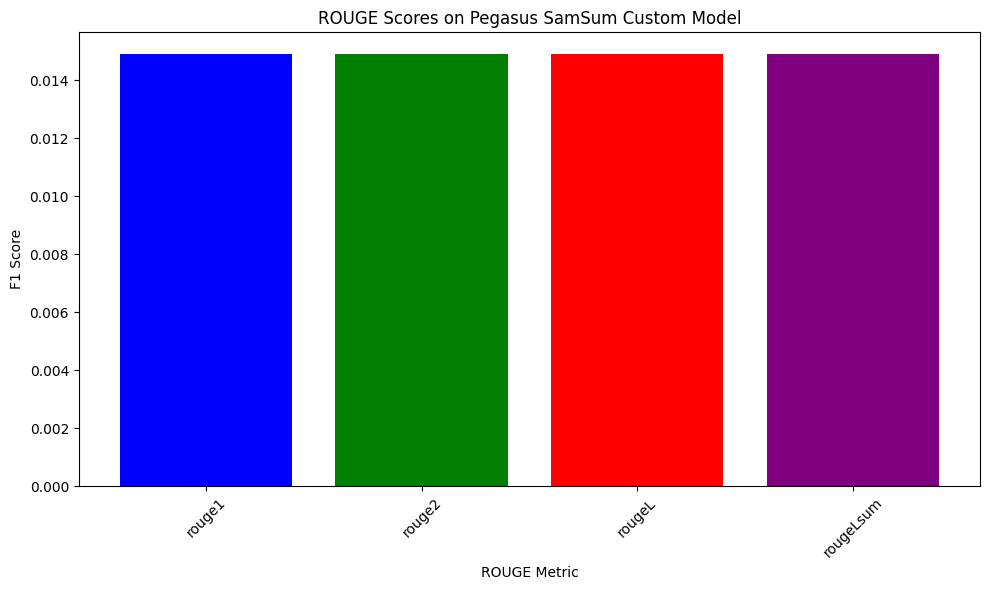

In [56]:
metrics = list(scores_df.columns)
values = scores_df.values.T[0]

colors = ['blue', 'green', 'red', 'purple']
plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=colors[:len(metrics)])

plt.title("ROUGE Scores on Pegasus SamSum Custom Model")
plt.xlabel("ROUGE Metric")
plt.ylabel("F1 Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Our ROUGE scores (around 0.01) show the summaries are quite different from the references. More training data and/or higher epochs might improve this. While the model generates summaries, the ROUGE scores (0.01) suggest significant gaps between generated summaries and ideal summaries.

Let us now go ahead and save the model and tokenizer for further usage.

In [38]:
model.save_pretrained("pegasus-samsum-model-1.0")
tokenizer.save_pretrained("tokenizer")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 128, 'min_length': 32, 'num_beams': 8, 'length_penalty': 0.8, 'forced_eos_token_id': 1}


('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/spiece.model',
 'tokenizer/added_tokens.json',
 'tokenizer/tokenizer.json')

# Loading our Custom Model
Now, we can go ahead and load our custom model and begin to inference it.

In [41]:
tokenizer = AutoTokenizer.from_pretrained("/content/tokenizer")
gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 128}

Now, we can go ahead and build a pipeline to inference our model.

In [45]:
pipeline_model = pipeline(
    "summarization",
    model="pegasus-samsum-model-1.0",
    tokenizer=tokenizer
)

## Checking with sample data from the dataset.

In [52]:
sample_text = dataset["test"][0]["dialogue"]
sample_target_summary = dataset["test"][0]["summary"]

In [53]:
sample_response = pipeline_model(sample_text, **gen_kwargs)
generated_summary = sample_response[0]["summary_text"]

Your max_length is set to 128, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


In [54]:
print("\033[1mSample Dialogue\033[0m:")
print(sample_text)
print("\n\033[1mTarget Summary\033[0m:")
print(sample_target_summary)
print("\n\033[1mGenerated Summary\033[0m:")
print(generated_summary)

Sample Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Target Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.

Generated Summary:
Amanda: Ask Larry Amanda: He called her last time we were at the park together .<n>Hannah: I'd rather you texted him .<n>Amanda: Just text him .


From what we can see, our custom model captures the gist of the conversation (needing a number, contacting Larry) but omits key details (Hannah's hesitation) and repeats some information. Training on more data and fine-tuning for dialogue summarization could improve conciseness and information selection.

Further adding more training points and enhancing the number of epochs could be of great additional value to our model's performance.